## About
This notebook uses ensembles generated by the [IDPSam collab notebook](https://colab.research.google.com/github/giacomo-janson/idpsam/blob/main/notebooks/idpsam_experiments.ipynb). 

### References

Janson, G. & Feig, M. Transferable deep generative modeling of intrinsically disordered protein conformations. PLoS Comput. Biol. 20, e1012144 (2024).
  


In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis

from scipy.signal import savgol_filter

	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from starling import load_ensemble
from protfasta import read_fasta
seqs = read_fasta('all_seqs.fasta')
from soursop.sstrajectory import SSTrajectory
from afrc import AnalyticalFRC
import protfasta

In [2]:
def rmse(d1,d2):
    """
    Returns the root-mean-squared (RMSE) between two 
    vectors.

    Parameters
    -----------
    d1 : np.ndarray or list
        1D array with one set of values

    d2 : np.ndarray or list
        1D array with another set of values

    Returns
    -----------
    float
        Returns the RMSE     
    
    """

    if len(d1) != len(d2):
        raise ValueError('Input vectors must be same length')
    
    return np.sqrt(np.mean((np.array(d1) - np.array(d2))**2))


In [3]:
seqs = protfasta.read_fasta('all_seqs.fasta')

In [5]:
ensembles = {}
idpSAM_ensembles = {}
saxs_rg = {}
for k in seqs:
    ensembles[k] = load_ensemble(f'STARLING_ensembles/{k}.starling')
    idpSAM_ensembles[k] = SSTrajectory(f'idpSAM/{k}/output/pept.ca.traj.dcd', f'idpSAM/{k}/output/pept.ca.top.pdb').proteinTrajectoryList[0]
    saxs_rg[k] = float(np.loadtxt(f'idpSAM/{k}/experiment.txt'))

In [6]:
saxs_vector = []
starling_vector = []
idpSAM_vector = []
afrc_vector = []

for k in seqs:
    saxs_vector.append(saxs_rg[k])
    starling_vector.append(ensembles[k].radius_of_gyration(return_mean=True))
    idpSAM_vector.append(np.mean(idpSAM_ensembles[k].get_radius_of_gyration()))
    afrc_vector.append(AnalyticalFRC(ensembles[k].sequence).get_mean_radius_of_gyration())

AFRC model r2 values: 0.9
AFRC model RMSE values: 3.58


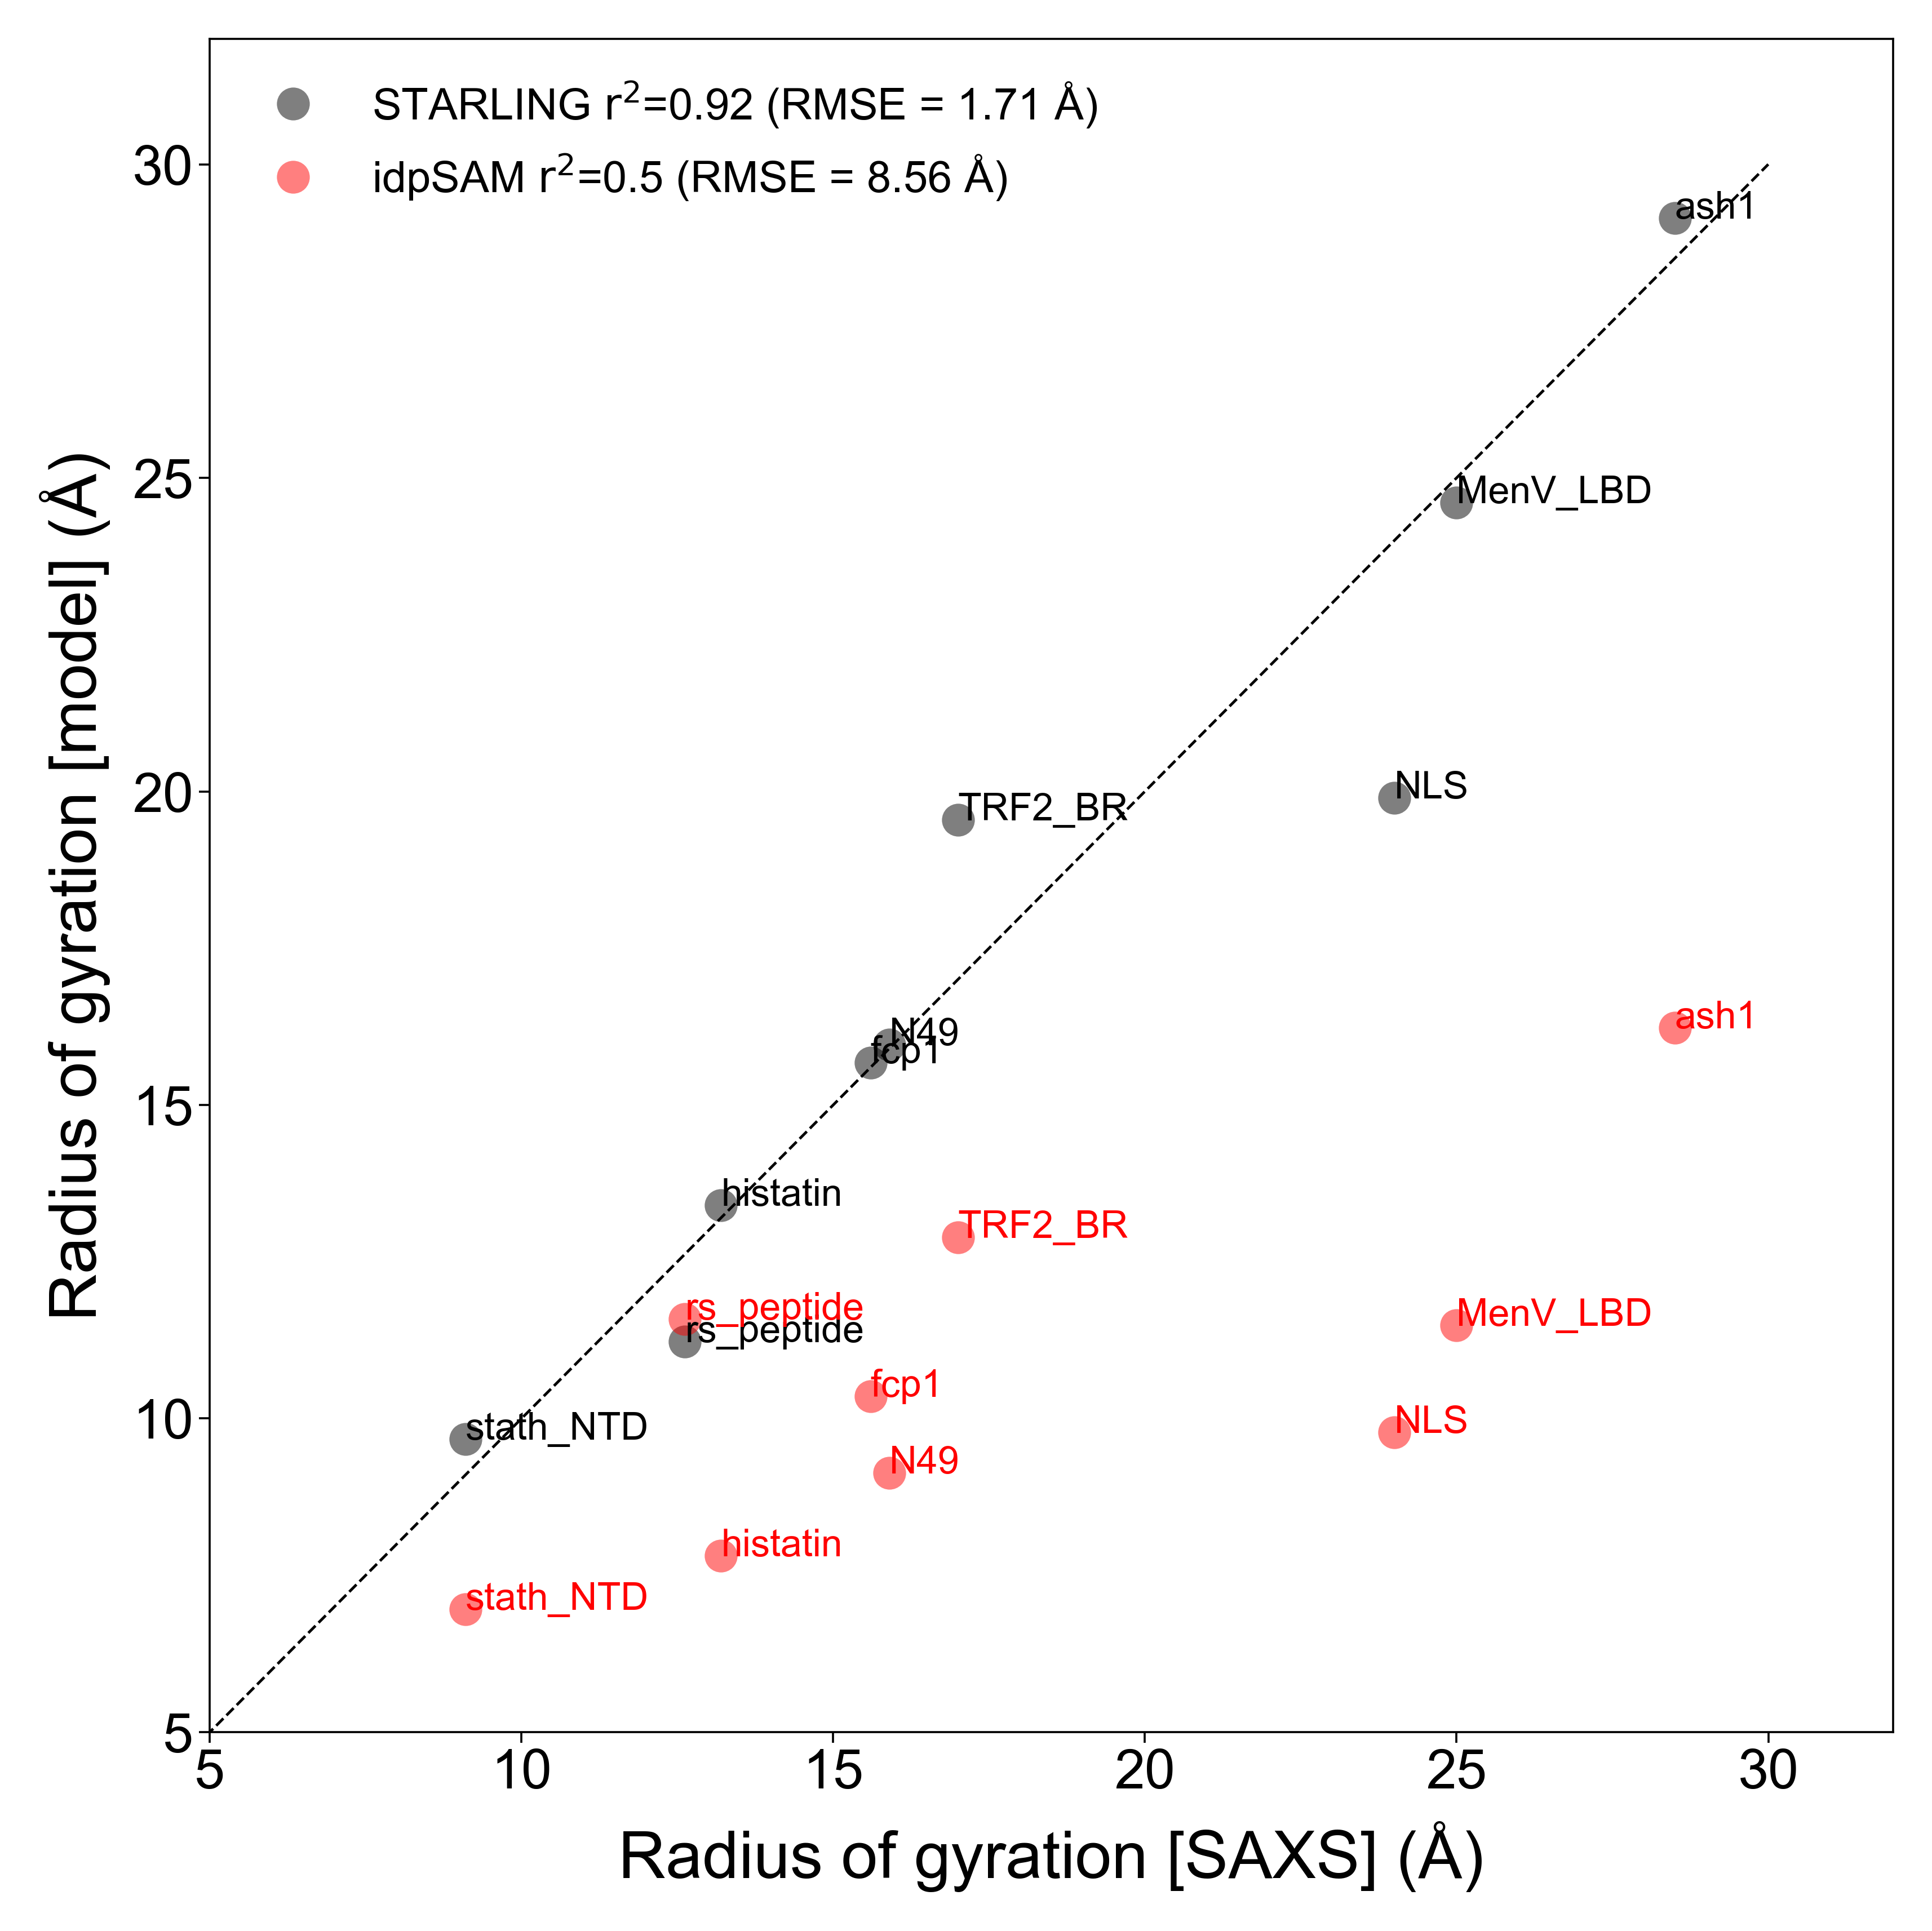

In [7]:
figure(None, (5,5), dpi=350)



r2_starling   = round(np.power(np.corrcoef(saxs_vector,starling_vector)[0][1],2),2)
r2_idpSAM     = round(np.power(np.corrcoef(saxs_vector,idpSAM_vector)[0][1],2),2)
r2_afrc       = round(np.power(np.corrcoef(saxs_vector,afrc_vector)[0][1],2),2)

                      
rmse_starling = round(rmse(saxs_vector,starling_vector),2)
rmse_idpSAM   = round(rmse(saxs_vector,idpSAM_vector),2)
rmse_afrc     = round(rmse(saxs_vector,afrc_vector),2)

for k in seqs:
    plt.text(saxs_rg[k], ensembles[k].radius_of_gyration(return_mean=True), k, fontsize=7, color='k')

for k in seqs:
    plt.text(saxs_rg[k], np.mean(idpSAM_ensembles[k].get_radius_of_gyration()), k, fontsize=7, color='r')


plt.plot(saxs_vector, starling_vector, 'ok', alpha=0.5, mew=0, label=r'STARLING $\rm r^2$'+ f'={r2_starling} (RMSE = {rmse_starling} Å)')
plt.plot(saxs_vector, idpSAM_vector, 'or', alpha=0.5, mew=0, label=r'idpSAM $\rm r^2$'+ f'={r2_idpSAM} (RMSE = {rmse_idpSAM} Å)')
plt.plot([0,30],[0,30],'--k', lw=0.5)
    
plt.xlim([5,32])
plt.ylim([5,32])
plt.legend(fontsize=8, frameon=False)
plt.xlabel('Radius of gyration [SAXS] (Å)',fontsize=12)
plt.ylabel('Radius of gyration [model] (Å)',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('figures/idpSAM_vs_STARLING.pdf')
print(f"AFRC model r2 values: {r2_afrc}")
print(f"AFRC model RMSE values: {rmse_afrc}")
